# Филиппов Денис


## Ccылка на Github с проектом:
https://github.com/phildens/non_toxic_bot

обученная модель:
https://disk.yandex.ru/d/OZXrlPr8j77Mzw

# Классификация русских комментариев: токсичность (Transformers)

В этом ноутбуке показаны **три** практичных сценария:
1. Мини-EDA: посмотрим на баланс классов и длины текстов.
2. **Подход A (эмбеддинги → классический ML)**: получаем эмбеддинги из трансформера и обучаем Logistic Regression.
3. **Подход B (fine-tuning)**: дообучаем трансформер под задачу бинарной классификации.

В конце сравним метрики, посмотрим типичные ошибки и протестируем модель на новых фразах.

> ⚠️ Данные берутся из датасета Kaggle *russian-language-toxic-comments* (файл `labeled.csv`).


## 0. Настройки и импорты

Соберём импорты в одном месте и зададим seed, чтобы результаты воспроизводились.

In [1]:
import os
import re
import shutil
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from datasets import Dataset

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# немного удобства для tqdm в pandas
tqdm.pandas()

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

## 1. Данные

Ниже — два варианта:
- через Kaggle CLI (если настроены токены);
- вручную: просто положите `labeled.csv` рядом с ноутбуком.

In [2]:
# (опционально) скачивание датасета через Kaggle CLI
# 1) установите kaggle: pip install kaggle
# 2) положите kaggle.json в ~/.kaggle/
# 3) раскомментируйте блок ниже

# DATA_DIR = "data"
# os.makedirs(DATA_DIR, exist_ok=True)
# !kaggle datasets download -d blackmoon/russian-language-toxic-comments -p {DATA_DIR}
# !unzip -o {DATA_DIR}/russian-language-toxic-comments.zip -d {DATA_DIR}


In [3]:
# загрузка labeled.csv
try:
    df = pd.read_csv("labeled.csv")
except FileNotFoundError:
    # если скачивали в папку data — попробуем оттуда
    alt_path = os.path.join("data", "labeled.csv")
    if os.path.exists(alt_path):
        df = pd.read_csv(alt_path)
    else:
        print("Не найден файл labeled.csv. Скачайте датасет и положите labeled.csv рядом с ноутбуком.")
        df = pd.DataFrame()

if not df.empty:
    df["toxic"] = df["toxic"].astype(int)
    df["comment"] = df["comment"].astype(str)

df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


## 2. Быстрый EDA

Смотрим баланс классов и распределение длины комментариев.

Размер датасета: (14412, 4)
Баланс классов (0/1):
toxic
0    9586
1    4826
Name: count, dtype: int64


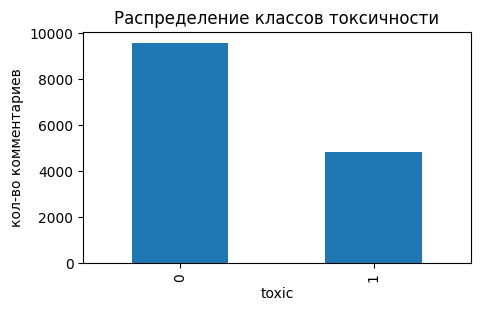

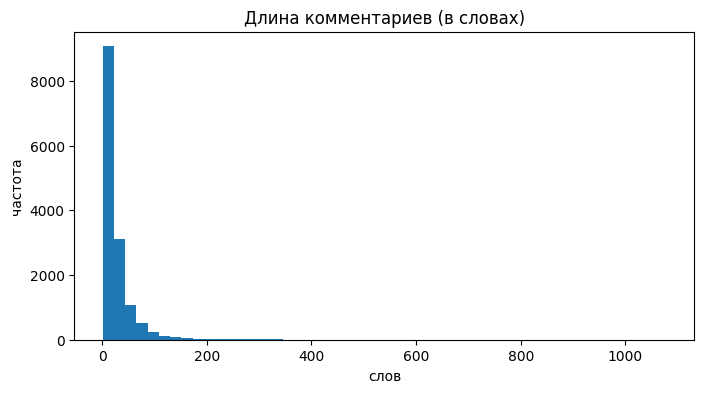

word_count: min/median/95%/max = 1 16 84 1078


In [4]:
if df.empty:
    print("DataFrame пуст — EDA пропускаем.")
else:
    # базовая статистика
    df["word_count"] = df["comment"].str.split().apply(len)
    df["unique_word_count"] = df["comment"].str.lower().str.split().apply(lambda x: len(set(x)))

    print("Размер датасета:", df.shape)
    print("Баланс классов (0/1):")
    print(df["toxic"].value_counts())

    fig, ax = plt.subplots(figsize=(5, 3))
    df["toxic"].value_counts().sort_index().plot(kind="bar", ax=ax)
    ax.set_title("Распределение классов токсичности")
    ax.set_xlabel("toxic")
    ax.set_ylabel("кол-во комментариев")
    plt.show()

    fig, ax = plt.subplots(figsize=(8, 4))
    df["word_count"].plot(kind="hist", bins=50, ax=ax)
    ax.set_title("Длина комментариев (в словах)")
    ax.set_xlabel("слов")
    ax.set_ylabel("частота")
    plt.show()

    print("word_count: min/median/95%/max =",
          int(df.word_count.min()),
          int(df.word_count.median()),
          int(df.word_count.quantile(0.95)),
          int(df.word_count.max()))


### 2.1 Облако слов










Небольшая иллюстрация частотных слов. Если не хочется тянуть NLTK/wordcloud — можно пропустить.

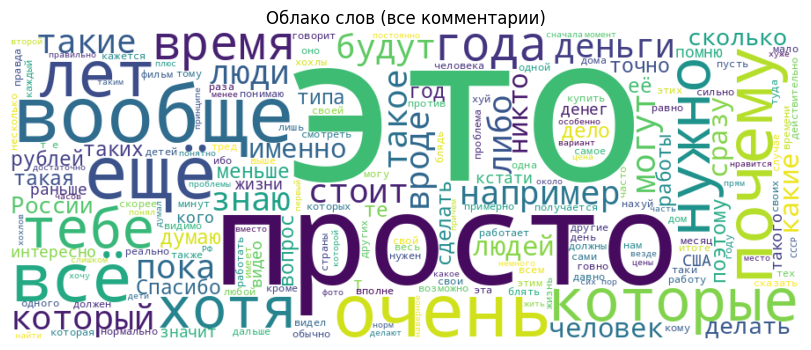

In [5]:
if df.empty:
    print("DataFrame пуст — wordcloud пропускаем.")
else:
    nltk.download("stopwords", quiet=True)
    ru_stop = set(stopwords.words("russian"))

    text_all = " ".join(df["comment"].dropna().tolist())
    wc = WordCloud(width=900, height=350, background_color="white", stopwords=ru_stop).generate(text_all)

    plt.figure(figsize=(12, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Облако слов (все комментарии)")
    plt.show()


## 3. Подготовка данных для моделей

- делаем стратифицированное разбиение;
- задаём `MAX_LEN` по 95-му перцентилю длины (с ограничением сверху);
- готовим `datasets.Dataset` для fine-tuning.

In [6]:
if df.empty:
    print("DataFrame пуст — подготовку пропускаем.")
else:
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=SEED, stratify=df["toxic"]
    )
    train_df, val_df = train_test_split(
        train_df, test_size=0.25, random_state=SEED, stratify=train_df["toxic"]
    )

    # MAX_LEN: 95-й перцентиль, но не больше 256 (чтобы не раздувать память)
    MAX_LEN = int(min(256, max(32, train_df["word_count"].quantile(0.95))))
    print("Размеры:", {"train": len(train_df), "val": len(val_df), "test": len(test_df)})
    print("MAX_LEN =", MAX_LEN)

    # для Trainer нужны Dataset
    hf_train = Dataset.from_pandas(train_df.reset_index(drop=True))
    hf_val = Dataset.from_pandas(val_df.reset_index(drop=True))
    hf_test = Dataset.from_pandas(test_df.reset_index(drop=True))


Размеры: {'train': 8646, 'val': 2883, 'test': 2883}
MAX_LEN = 83


## 4. Подход A: эмбеддинги + Logistic Regression

Идея: **заморозить** трансформер и использовать [CLS]-вектор как признаковое описание текста.

In [7]:
def embed_texts(texts, tokenizer, encoder, max_len: int, batch_size: int = 16):
    """Батчевое получение эмбеддингов [CLS]."""
    encoder.eval()
    all_vecs = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Embeddings"):
        batch = texts[i : i + batch_size]
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_len,
            return_tensors="pt",
        )
        enc = {k: v.to(DEVICE) for k, v in enc.items()}

        with torch.no_grad():
            out = encoder(**enc)

        # [CLS] = позиция 0
        vec = out.last_hidden_state[:, 0, :].detach().cpu().numpy()
        all_vecs.append(vec)

    return np.vstack(all_vecs)


def fit_lr_on_embeddings(train_texts, test_texts, y_train, y_test, encoder_name: str):
    tok = AutoTokenizer.from_pretrained(encoder_name)
    enc = AutoModel.from_pretrained(encoder_name, use_safetensors=True).to(DEVICE)

    X_tr = embed_texts(train_texts, tok, enc, MAX_LEN)
    X_te = embed_texts(test_texts, tok, enc, MAX_LEN)

    clf = LogisticRegression(max_iter=1500, random_state=SEED)
    clf.fit(X_tr, y_train)
    pred = clf.predict(X_te)

    print(f"\n=== {encoder_name} (Embeddings → LR) ===")
    print(classification_report(y_test, pred, digits=4))
    print("accuracy:", round(accuracy_score(y_test, pred), 4), "| f1:", round(f1_score(y_test, pred), 4))

    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["нетокс", "токс"])
    disp.plot(values_format="d")
    plt.title(f"Confusion matrix: {encoder_name}\n(Embeddings → LR)")
    plt.show()

    return {"name": encoder_name, "tokenizer": tok, "encoder": enc, "clf": clf, "pred": pred}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embeddings:   0%|          | 0/541 [00:00<?, ?it/s]

Embeddings:   0%|          | 0/181 [00:00<?, ?it/s]


=== DeepPavlov/rubert-base-cased (Embeddings → LR) ===
              precision    recall  f1-score   support

           0     0.8905    0.9202    0.9051      1918
           1     0.8302    0.7751    0.8017       965

    accuracy                         0.8717      2883
   macro avg     0.8604    0.8477    0.8534      2883
weighted avg     0.8703    0.8717    0.8705      2883

accuracy: 0.8717 | f1: 0.8017


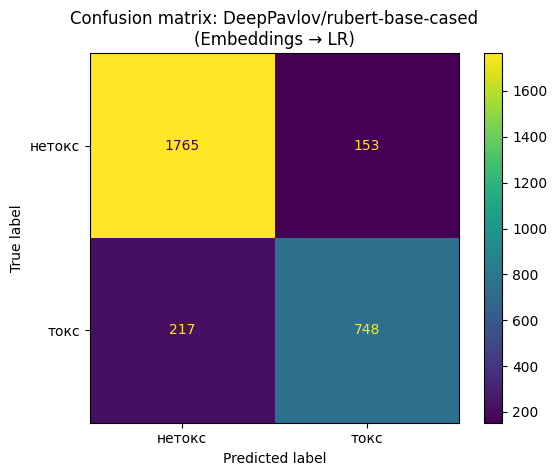

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

Embeddings:   0%|          | 0/541 [00:00<?, ?it/s]

Embeddings:   0%|          | 0/181 [00:00<?, ?it/s]


=== DeepPavlov/rubert-base-cased-sentence (Embeddings → LR) ===
              precision    recall  f1-score   support

           0     0.9005    0.9056    0.9030      1918
           1     0.8103    0.8010    0.8056       965

    accuracy                         0.8706      2883
   macro avg     0.8554    0.8533    0.8543      2883
weighted avg     0.8703    0.8706    0.8704      2883

accuracy: 0.8706 | f1: 0.8056


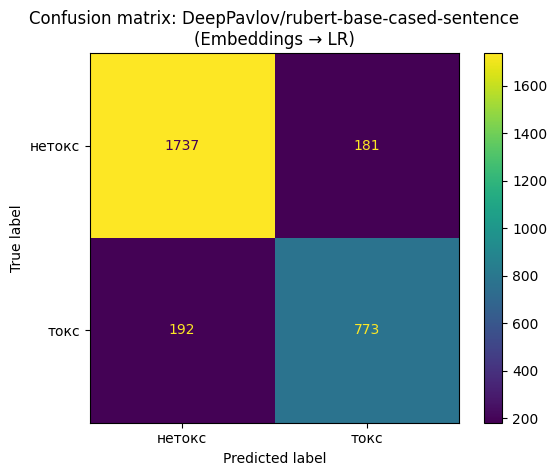


--- Сводка (эмбеддинги) ---
DeepPavlov/rubert-base-cased: accuracy=0.8717, f1=0.8017
DeepPavlov/rubert-base-cased-sentence: accuracy=0.8706, f1=0.8056


In [8]:
if df.empty:
    print("DataFrame пуст — обучение пропускаем.")
else:
    X_train_text = train_df["comment"].tolist()
    X_test_text = test_df["comment"].tolist()
    y_train = train_df["toxic"].values
    y_test = test_df["toxic"].values

    emb_model_1 = "DeepPavlov/rubert-base-cased"
    emb_model_2 = "DeepPavlov/rubert-base-cased-sentence"

    emb_res_1 = fit_lr_on_embeddings(X_train_text, X_test_text, y_train, y_test, emb_model_1)
    emb_res_2 = fit_lr_on_embeddings(X_train_text, X_test_text, y_train, y_test, emb_model_2)

    acc_emb_1 = accuracy_score(y_test, emb_res_1["pred"])
    f1_emb_1 = f1_score(y_test, emb_res_1["pred"])
    acc_emb_2 = accuracy_score(y_test, emb_res_2["pred"])
    f1_emb_2 = f1_score(y_test, emb_res_2["pred"])

    print("\n--- Сводка (эмбеддинги) ---")
    print(f"{emb_model_1}: accuracy={acc_emb_1:.4f}, f1={f1_emb_1:.4f}")
    print(f"{emb_model_2}: accuracy={acc_emb_2:.4f}, f1={f1_emb_2:.4f}")


## 5. Подход B: fine-tuning трансформера

Дообучаем `AutoModelForSequenceClassification` на нашей задаче (2 класса).

In [9]:
def make_tokenizer_and_datasets(model_name: str):
    tok = AutoTokenizer.from_pretrained(model_name)

    def tok_fn(batch):
        return tok(batch["comment"], truncation=True, padding="max_length", max_length=MAX_LEN)

    tr = hf_train.map(tok_fn, batched=True)
    va = hf_val.map(tok_fn, batched=True)
    te = hf_test.map(tok_fn, batched=True)

    # чистим лишнее и приводим label к 'labels' (как любит Trainer)
    drop_cols = [c for c in ["comment", "word_count", "unique_word_count"] if c in tr.column_names]
    tr = tr.remove_columns(drop_cols).rename_column("toxic", "labels")
    va = va.remove_columns(drop_cols).rename_column("toxic", "labels")
    te = te.remove_columns(drop_cols).rename_column("toxic", "labels")

    return tok, tr, va, te


def metrics_fn(eval_pred):
    logits, labels = eval_pred
    pred = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, pred),
        "f1": f1_score(labels, pred),
        "precision": precision_score(labels, pred),
        "recall": recall_score(labels, pred),
    }


def finetune(model_name: str, out_dir: str, tokenizer, train_ds, val_ds):
    """Fine-tuning HF модели для бинарной классификации."""
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        use_safetensors=True,
        problem_type="single_label_classification",
        ignore_mismatched_sizes=True,
    ).to(DEVICE)

    args = TrainingArguments(
        output_dir=out_dir,
        num_train_epochs=1,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        weight_decay=0.01,
        warmup_steps=500,
        logging_dir=os.path.join(out_dir, "logs"),
        logging_steps=100,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        report_to="none",
        seed=SEED,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=metrics_fn,
    )
    trainer.train()
    return trainer


Map:   0%|          | 0/8646 [00:00<?, ? examples/s]

Map:   0%|          | 0/2883 [00:00<?, ? examples/s]

Map:   0%|          | 0/2883 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3163379979.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.314600,0.256504,0.907388,0.861730,0.862176,0.861284



=== DeepPavlov/rubert-base-cased (Fine-tuning) ===
              precision    recall  f1-score   support

           0     0.9300    0.9286    0.9293      1918
           1     0.8585    0.8611    0.8598       965

    accuracy                         0.9060      2883
   macro avg     0.8942    0.8949    0.8946      2883
weighted avg     0.9061    0.9060    0.9060      2883

accuracy: 0.906 | f1: 0.8598


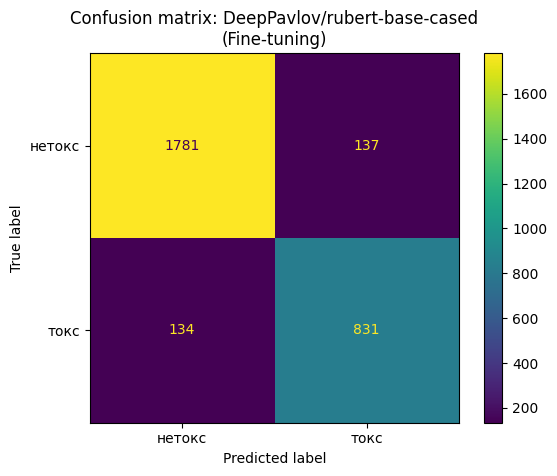

Map:   0%|          | 0/8646 [00:00<?, ? examples/s]

Map:   0%|          | 0/2883 [00:00<?, ? examples/s]

Map:   0%|          | 0/2883 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3163379979.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.272500,0.257109,0.903226,0.847956,0.895282,0.805383



=== DeepPavlov/rubert-base-cased-sentence (Fine-tuning) ===
              precision    recall  f1-score   support

           0     0.9049    0.9526    0.9281      1918
           1     0.8947    0.8010    0.8453       965

    accuracy                         0.9018      2883
   macro avg     0.8998    0.8768    0.8867      2883
weighted avg     0.9015    0.9018    0.9004      2883

accuracy: 0.9018 | f1: 0.8453


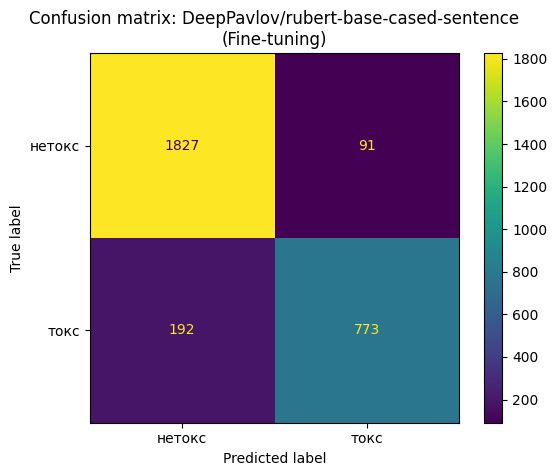

In [10]:
if df.empty:
    print("DataFrame пуст — fine-tuning пропускаем.")
else:
    ft_model_1 = "DeepPavlov/rubert-base-cased"
    ft_model_2 = "DeepPavlov/rubert-base-cased-sentence"

    # датасеты токенизируются под конкретный токенизатор
    tokenizer_ft, tok_train, tok_val, tok_test = make_tokenizer_and_datasets(ft_model_1)
    trainer_ft_1 = finetune(ft_model_1, "./ft_rubert_base", tokenizer_ft, tok_train, tok_val)

    pred_ft_1 = trainer_ft_1.predict(tok_test)
    y_pred_ft_1 = np.argmax(pred_ft_1.predictions, axis=-1)
    y_true = np.array(tok_test["labels"])

    print(f"\n=== {ft_model_1} (Fine-tuning) ===")
    print(classification_report(y_true, y_pred_ft_1, digits=4))
    print("accuracy:", round(accuracy_score(y_true, y_pred_ft_1), 4), "| f1:", round(f1_score(y_true, y_pred_ft_1), 4))

    cm = confusion_matrix(y_true, y_pred_ft_1)
    ConfusionMatrixDisplay(cm, display_labels=["нетокс", "токс"]).plot(values_format="d")
    plt.title(f"Confusion matrix: {ft_model_1}\n(Fine-tuning)")
    plt.show()

    # для второй модели — токенизатор/датасеты отдельно
    tokenizer_ft2, tok_train2, tok_val2, tok_test2 = make_tokenizer_and_datasets(ft_model_2)
    trainer_ft_2 = finetune(ft_model_2, "./ft_rubert_sentence", tokenizer_ft2, tok_train2, tok_val2)

    pred_ft_2 = trainer_ft_2.predict(tok_test2)
    y_pred_ft_2 = np.argmax(pred_ft_2.predictions, axis=-1)
    y_true2 = np.array(tok_test2["labels"])

    print(f"\n=== {ft_model_2} (Fine-tuning) ===")
    print(classification_report(y_true2, y_pred_ft_2, digits=4))
    print("accuracy:", round(accuracy_score(y_true2, y_pred_ft_2), 4), "| f1:", round(f1_score(y_true2, y_pred_ft_2), 4))

    cm2 = confusion_matrix(y_true2, y_pred_ft_2)
    ConfusionMatrixDisplay(cm2, display_labels=["нетокс", "токс"]).plot(values_format="d")
    plt.title(f"Confusion matrix: {ft_model_2}\n(Fine-tuning)")
    plt.show()


## 6. Сравнение и выбор лучшей модели

В качестве простого критерия возьмём **F1** на тесте.

In [11]:
if df.empty:
    print("DataFrame пуст — сравнение пропускаем.")
else:
    scores = []

    # embeddings
    scores.append(("emb", emb_model_1, f1_score(y_test, emb_res_1["pred"]), emb_res_1))
    scores.append(("emb", emb_model_2, f1_score(y_test, emb_res_2["pred"]), emb_res_2))

    # fine-tuning
    scores.append(("ft", ft_model_1, f1_score(y_true, y_pred_ft_1), ("ft1", trainer_ft_1, tokenizer_ft, ft_model_1)))
    scores.append(("ft", ft_model_2, f1_score(y_true2, y_pred_ft_2), ("ft2", trainer_ft_2, tokenizer_ft2, ft_model_2)))

    scores_sorted = sorted(scores, key=lambda x: x[2], reverse=True)
    for kind, name, f1v, _ in scores_sorted:
        print(f"{kind:>3} | {name:<40} | f1={f1v:.4f}")

    best_kind, best_name, best_f1, best_payload = scores_sorted[0]
    print("\nЛучшая по F1:", best_kind, best_name, f"({best_f1:.4f})")


 ft | DeepPavlov/rubert-base-cased             | f1=0.8598
 ft | DeepPavlov/rubert-base-cased-sentence    | f1=0.8453
emb | DeepPavlov/rubert-base-cased-sentence    | f1=0.8056
emb | DeepPavlov/rubert-base-cased             | f1=0.8017

Лучшая по F1: ft DeepPavlov/rubert-base-cased (0.8598)


## 7. Анализ ошибок лучшей модели

Посмотрим матрицу ошибок и несколько примеров FP/FN.

In [12]:
def show_error_examples(texts, y_true, y_pred, n_show=5):
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["нетокс", "токс"]).plot(values_format="d")
    plt.title("Матрица ошибок (лучшая модель)")
    plt.show()

    wrong = np.where(y_true != y_pred)[0]
    print("Ошибок:", len(wrong), "из", len(y_true))

    print("\nНесколько промахов:")
    for i in wrong[:n_show]:
        print("-" * 80)
        print("text:", texts[i])
        print("true:", int(y_true[i]), "| pred:", int(y_pred[i]))

    fp = np.where((y_pred == 1) & (y_true == 0))[0]
    fn = np.where((y_pred == 0) & (y_true == 1))[0]
    print("\nFP (0→1):", len(fp), "| FN (1→0):", len(fn))
    print("Пример FP:", texts[fp[0]] if len(fp) else "нет")
    print("Пример FN:", texts[fn[0]] if len(fn) else "нет")


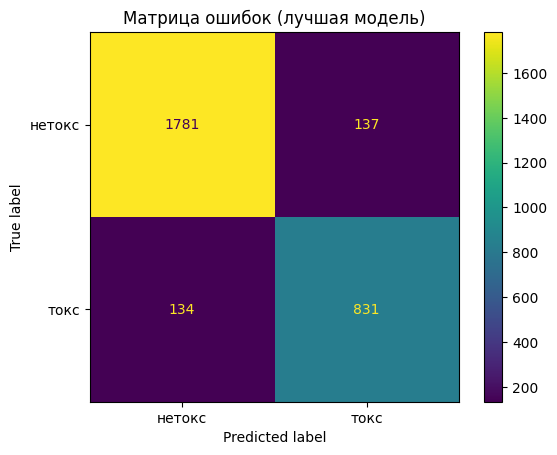

Ошибок: 271 из 2883

Несколько промахов:
--------------------------------------------------------------------------------
text: добби свободен!!!!!!!!!!!!!!!!!!!! ох спасибо тебе добрая внученька!!!!!!!!!!!!!!!!!

true: 0 | pred: 1
--------------------------------------------------------------------------------
text: Каких-каких изуверских практик? Там ежа надо жрать пока его любишь?
true: 0 | pred: 1
--------------------------------------------------------------------------------
text: Так не ноль, а нуль. Так как математику подменили, осмелюсь предположить, что в системе счёта древних русов, нуль - это не то же самое, что и ноль мимо
true: 1 | pred: 0
--------------------------------------------------------------------------------
text: Идиоты проникают во все сферы жизни 5 дней снимает ролики с зумом на фурункул

true: 1 | pred: 0
--------------------------------------------------------------------------------
text: Не, мы лучше вас прислоним)

true: 1 | pred: 0

FP (0→1): 137 | FN 

In [13]:
if df.empty:
    print("DataFrame пуст — анализ ошибок пропускаем.")
else:
    test_texts = test_df.reset_index(drop=True)["comment"].tolist()

    if best_kind == "emb":
        best_pred = best_payload["pred"]
        best_true = y_test
    else:
        # у fine-tuning есть две ветки — выберем правильную по имени
        if best_name == ft_model_1:
            best_pred, best_true = y_pred_ft_1, y_true
        else:
            best_pred, best_true = y_pred_ft_2, y_true2

    show_error_examples(test_texts, np.array(best_true), np.array(best_pred), n_show=5)


## 8. Проверка на новых фразах

Один интерфейс — два режима (эмбеддинги или fine-tuning).

In [14]:
NEW_TEXTS = [
    "Ты совсем идиот?",
    "Ты просто ужасен, как можно так говорить?",
    "Сегодня отличная погода для прогулки.",
    "Я ненавижу тебя и все, что ты делаешь.",
    "Привет, как дела? Надеюсь, у тебя все хорошо.",
    "хочется видеть структуру (Заголовки разного уровня);",
    "ожидается видеть не только код, но и комментарии к нему;",
    "не должно быть запущенных ячеек с ошибками;",
    "ожидается что рисунки адекватно оформлены (не маленького размера, есть описание того, что на рисунке)",
    "Рисунков - адекватное количество. Т.е. вы не закидываете в меня 100 графиков без каких-то комментариев. Оставьте самое полезное с т.з. сторитейлинга.",
]


In [15]:
def predict_texts(texts, kind: str):
    if kind == "emb":
        tok = best_payload["tokenizer"]
        enc = best_payload["encoder"]
        clf = best_payload["clf"]
        vec = embed_texts(texts, tok, enc, MAX_LEN, batch_size=16)
        return clf.predict(vec)
    else:
        if best_name == ft_model_1:
            tok = tokenizer_ft
            tr = trainer_ft_1
        else:
            tok = tokenizer_ft2
            tr = trainer_ft_2

        enc = tok(texts, truncation=True, padding="max_length", max_length=MAX_LEN, return_tensors="pt")
        class TmpDS(torch.utils.data.Dataset):
            def __init__(self, encodings):
                self.encodings = encodings
            def __len__(self):
                return len(self.encodings["input_ids"])
            def __getitem__(self, idx):
                return {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}

        ds = TmpDS(enc)
        pred = tr.predict(ds)
        return np.argmax(pred.predictions, axis=-1)


if df.empty:
    print("DataFrame пуст — демо пропускаем.")
else:
    pred_new = predict_texts(NEW_TEXTS, best_kind)

    print("=" * 120)
    print(f"{'№':<3} | {'ТЕКСТ':<60} | {'ПРЕДСКАЗАНИЕ':<12}")
    print("=" * 120)
    for i, (t, p) in enumerate(zip(NEW_TEXTS, pred_new), 1):
        label = "Токсичный" if int(p) == 1 else "Нетоксичный"
        short = t if len(t) <= 57 else t[:54] + "..."
        print(f"{i:<3} | {short:<60} | {label:<12}")
    print("=" * 120)


/tmp/ipython-input-2183777973.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}


№   | ТЕКСТ                                                        | ПРЕДСКАЗАНИЕ
1   | Ты совсем идиот?                                             | Токсичный   
2   | Ты просто ужасен, как можно так говорить?                    | Токсичный   
3   | Сегодня отличная погода для прогулки.                        | Нетоксичный 
4   | Я ненавижу тебя и все, что ты делаешь.                       | Токсичный   
5   | Привет, как дела? Надеюсь, у тебя все хорошо.                | Токсичный   
6   | хочется видеть структуру (Заголовки разного уровня);         | Нетоксичный 
7   | ожидается видеть не только код, но и комментарии к нему;     | Нетоксичный 
8   | не должно быть запущенных ячеек с ошибками;                  | Нетоксичный 
9   | ожидается что рисунки адекватно оформлены (не маленько...    | Нетоксичный 
10  | Рисунков - адекватное количество. Т.е. вы не закидывае...    | Нетоксичный 


## 9. Сохранение лучшей модели

Сохраним модель и токенизатор в папку (а затем — в zip). Для fine-tuning сохраняется `Trainer.model`, для эмбеддингов — классификатор LR и имя энкодера (через `joblib`).

In [ ]:
import joblib

SAVE_DIR = "best_toxic_model"

if df.empty:
    print("DataFrame пуст — сохранение пропускаем.")
else:
    os.makedirs(SAVE_DIR, exist_ok=True)

    if best_kind == "ft":
        # безопасно переносим на CPU перед сохранением
        best_model = (trainer_ft_1.model if best_name == ft_model_1 else trainer_ft_2.model).to("cpu")
        best_tok = (tokenizer_ft if best_name == ft_model_1 else tokenizer_ft2)

        best_model.save_pretrained(SAVE_DIR)
        best_tok.save_pretrained(SAVE_DIR)
        meta = {"kind": "ft", "model_name": best_name, "max_len": MAX_LEN, "seed": SEED}
        joblib.dump(meta, os.path.join(SAVE_DIR, "meta.joblib"))
        print("Сохранено (fine-tuning):", SAVE_DIR)

    else:
        # сохраняем LR + метаданные (энкодер можно скачать по имени)
        meta = {"kind": "emb", "encoder_name": best_name, "max_len": MAX_LEN, "seed": SEED}
        joblib.dump(best_payload["clf"], os.path.join(SAVE_DIR, "lr.joblib"))
        joblib.dump(meta, os.path.join(SAVE_DIR, "meta.joblib"))
        print("Сохранено (embeddings):", SAVE_DIR)

    archive_path = shutil.make_archive(SAVE_DIR, "zip", SAVE_DIR)
    print("Готов zip-архив:", archive_path)


## Ccылка на Github с проектом:
https://github.com/phildens/non_toxic_bot